# Food Vision Big



## Check GPU

Google Colab offers free GPUs, not all of them are compatible with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to Tesla T4 (from within colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see hardware here: https://developer.nvidia.com/cuda-gpus).

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e57dc3ea-6bab-3315-628d-79732fe12cbf)


In [ ]:
# !wget : https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
# Import some of the helper functions
# from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Setup and data loading

This example requires TensorFlow 2.3 or above.

To use TPU, the TPU runtime must match current running TensorFlow version. If there is a mismatch, try:

In [ ]:
# from cloud_tpu_client import Client
# c = Client()
# c.configure_tpu_version(tf.__version__, restart_type="always")

In [ ]:
# import tensorflow as tf

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#     print("Device:", tpu.master())
#     strategy = tf.distribute.TPUStrategy(tpu)
# except ValueError:
#     print("Not connected to a TPU runtime. Using CPU/GPU strategy")
#     strategy = tf.distribute.MirroredStrategy()

## Use TensorFlow Dataset (TFDS) to Download Data

In [ ]:
# Import tensorflow dataset 
import tensorflow_datasets as tfds

In [ ]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # Check whether food101 dataset is present or not?

True


In [ ]:
# Load in the data (in Colab it will take 5-6 minutes)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # dataset get returned in tuple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteNUU1FI/food101-train.tfrecord*...:   0%|          …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteNUU1FI/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Dataset

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The data type of our input data
* What the labels look like (e.g. are they one-hot encode or label encoded)
* Do the labels match up with the class names

In [ ]:
# Get the features of the dataset, dataset_size and description
print(f"Features : {ds_info.features}\n\nDataset Size: {ds_info.dataset_size}\n\nDescription of the Dataset: {ds_info.description}")

Features : FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

Dataset Size: 4.77 GiB

Description of the Dataset: This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.


In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
# Take one sample of the train data 
train_one_sample = train_data.take(1) # the samples are in format (image tensor, label)

# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output information about our training samples
for image, label in train_one_sample:
  print(f"""
  Image Shape: {image.shape}
  Image Datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class names (str form): {class_names[label.numpy()]}
  """)


  Image Shape: (512, 512, 3)
  Image Datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 38
  Class names (str form): fish_and_chips
  


In [ ]:
import tensorflow as tf

# Getting the minimum and maximum values of image tensor?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

**Observations :**
* Image Size: size of the images are not fixed
* Data Type: datatype of the images are not float32 
* Labels: labels are not one-hot encoded
* Image Values: images are not scaled

## Plot some images from tensorflow dataset

(-0.5, 511.5, 511.5, -0.5)

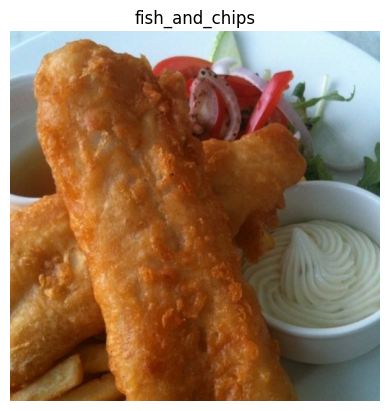

In [ ]:
import matplotlib.pyplot as plt

# Plot an image tensor
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to the image, to verify the label is associated with right image
plt.axis(False)

## Create preprocessing functions for our data

Neural Networks perform best when the data is in a certain way (e.g. batched, normalized, etc.)

However, not all data (including data from TensorFlow Datasets) comes like this.

So, in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about out data:
* In `uint8` data type
* Comparised of all different size of tensor (different image shape)
* Not Scaled (the pixel values are between 0 and 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size.
* Scaled (values between 0 and 1) also called normalized tensors, generally perform better.

With these point in mind, we've got a few things we can tackle with a preprocessing function.

Since, we're going to use EfficientNetBx pretrained model form tf.keras.applications we don't need to rescale our data (these architecture have rescaling built-in).

This means our function needs to do:
1. Reshape our images to all the same shape.
2. Coonvert the dtype of our image tensors from `uint8` to `float32`.

In [ ]:
# Make a function for preprocessing image
def preprocess_img(image, label, img_shape=224):
  """
    Converts image data type from `uint8` to `float32` and reshapes images to 
    [img_shape, img_shape, color_channels]
  """

  image = tf.image.resize(image, [img_shape, img_shape])
  image = image/255.0 # scale images between 0 & 1 (not required in EfficientNet)
  return tf.cast(image, tf.float32), label  # return tuple of (float32 image, label)

In [ ]:
# Preprocess a single image and check the output
preprocessed_img = preprocess_img(image, label)[0]

print(f"Image before preprocessing:\n {image[:2]}...\nShape: {image.shape}\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...\nShape: {preprocessed_img.shape}\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[182 225 242]
  [180 223 240]
  [179 220 238]
  ...
  [157 202 221]
  [157 204 222]
  [158 205 223]]

 [[179 222 239]
  [178 221 238]
  [178 219 237]
  ...
  [162 207 226]
  [162 209 227]
  [163 210 228]]]...
Shape: (512, 512, 3)
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[0.7027411  0.8713685  0.9380352 ]
  [0.69813925 0.85892355 0.9295118 ]
  [0.72240895 0.86582637 0.9411765 ]
  ...
  [0.64595836 0.8089436  0.8862745 ]
  [0.6259504  0.802421   0.87693083]
  [0.62969196 0.81400573 0.88459396]]

 [[0.6953382  0.86396563 0.9306323 ]
  [0.697499   0.8582833  0.9288716 ]
  [0.72162867 0.8667267  0.9412365 ]
  ...
  [0.63971585 0.7981595  0.8773711 ]
  [0.6655862  0.8352942  0.909804  ]
  [0.6610643  0.8406964  0.9136254 ]]]...
Shape: (224, 224, 3)
Datatype: <dtype: 'float32'>


## Batch and Prepare datasets

We're going to make our data input pipeline run really fast.

For more resources visit: https://www.tensorflow.org/guide/data_performance

In [ ]:
# Map preprocessing functions to training and parallelise
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle the train data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing functions to test data 
test_data = test_data.map(map_func=preprocess_img, 
                          num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> Hey TensorFlow, map this preprocessing function (preprocess_img) across our training dataset then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) on the current batch.

## Create Modelling Callbacks

We're going to create a couple of callbacks to help us while our model trains:
* **TensorBoard Callback** to log the training result (so we can visualize them later)
* **ModelCheckpoint Callback** to save our model's progress after feature extraction.

In [ ]:
# Create tensorboard callbacks 
import datetime

# Creating tensorboard callback
tensorboard_path = f"tensorboard_logs/food_vision_feature_extraction/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path)

# Create a model check point callback to save our model's progress during training
checkpoint_path = "model_checkpoint/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc", 
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1)

## Setup mixed precision training

Mixed precision utilizes a combination of float32 and float16 data type to speed up the model performance.

In [ ]:
# Turned on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16') # Set global data plicy to mixed precision

In [ ]:
# Checking the global policy
mixed_precision.global_policy()

<Policy "mixed_float16">

## Data Augmentation 

* Data augmentation is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data.
* We can create new data by RandomRotation, RandomFlip, RandomZoom, etc of the existing data.
* Data Augmentation is basically used to remove overfitting while training the model.

In [ ]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomWidth(0.3),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomHeight(0.3)
], name="data_augmentation")

## Build Feature Extraction model

Here, we are using Functional API to create the model.

In [ ]:
# Set the random seed value
tf.keras.utils.set_random_seed(7)

INPUT_SHAPE = (224, 224, 3)

# Create base model the model 
base_model = tf.keras.applications.vgg19.VGG19(include_top=False) # include_top=False means the output layer is not included in the base model.
base_model.trainable = False  

# Create functional model
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE, name="input_layer")

# Note: EfficientNetBx model have rescaling built-in but if our model is like Resnet we've to do rescaling
# x = tf.keras.layers.Rescaling(1/255.0)

# Augmenting the data
x = data_augmentation(inputs)

x = base_model(inputs, training=False)

# Create global average pooling layer
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
# It basically perform downsampling by computing the mean of the height and width dimension of input. 

# Adding dropout layer
x = tf.keras.layers.Dropout(rate=0.10, seed=7)(x)

# Creating dense layer
x = tf.keras.layers.Dense(units=len(class_names), name="output_layer")(x)
outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)

# Create the model
model = tf.keras.Model(inputs, outputs, name="FoodVisionVGG19")

# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Dealing with label encoded labels
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "FoodVisionVGG19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling_laye  (None, 512)              0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 output_layer (Dense)        (None, 101)               51813     
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                 

## Checking layer Data Type policies (are we using mixed precision training?)

In [ ]:
# checking the data type of the model's layers
for layer_number, layer in enumerate(model.layers):
  print(layer_number, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 input_layer True float32 <Policy "float32">
1 vgg19 False float32 <Policy "mixed_float16">
2 global_average_pooling_layer True float32 <Policy "mixed_float16">
3 dropout True float32 <Policy "mixed_float16">
4 output_layer True float32 <Policy "mixed_float16">
5 softmax_float32 True float32 <Policy "float32">


Going through above we see:
* `layer.name`: the human readable name of the layer
* `layer.trainable`: is the layer trainable or not? (if `False`, the weight are frozen)
* ` layer.dtype`: the data type a layer used to store its variables
* `layer.dtype_policy`: the data type policy a layer computes on its variable with

In [ ]:
# Checking the dtype of the base model layers
for layer_number, layer in enumerate(model.layers[1].layers):
  print(layer_number, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 input_1 False float32 <Policy "float32">
1 block1_conv1 False float32 <Policy "mixed_float16">
2 block1_conv2 False float32 <Policy "mixed_float16">
3 block1_pool False float32 <Policy "mixed_float16">
4 block2_conv1 False float32 <Policy "mixed_float16">
5 block2_conv2 False float32 <Policy "mixed_float16">
6 block2_pool False float32 <Policy "mixed_float16">
7 block3_conv1 False float32 <Policy "mixed_float16">
8 block3_conv2 False float32 <Policy "mixed_float16">
9 block3_conv3 False float32 <Policy "mixed_float16">
10 block3_conv4 False float32 <Policy "mixed_float16">
11 block3_pool False float32 <Policy "mixed_float16">
12 block4_conv1 False float32 <Policy "mixed_float16">
13 block4_conv2 False float32 <Policy "mixed_float16">
14 block4_conv3 False float32 <Policy "mixed_float16">
15 block4_conv4 False float32 <Policy "mixed_float16">
16 block4_pool False float32 <Policy "mixed_float16">
17 block5_conv1 False float32 <Policy "mixed_float16">
18 block5_conv2 False float32 <Poli

## Fit the feature extraction model:

If our goal is to fine-tune a model, the general order of doing is:
1. Build a feature extraction model (train a couple of output layers with base layers frozen).
2. Fine-tune some (or all) of the frozen layers.

In [ ]:
# Fit the model
history = model.fit(train_data,
                    epochs=3,
                    validation_data=test_data,
                    validation_steps=int(0.30 * len(test_data)), # Here we, are using 30% of test data for validation purpose.
                    callbacks=[tensorboard_callback,
                               model_checkpoint])

Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 3.9688 - accuracy: 0.1324

2368/2368 [==============================] - 197s 76ms/step - loss: 3.9688 - accuracy: 0.1324 - val_loss: 3.4684 - val_accuracy: 0.2358
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 3.4495 - accuracy: 0.2178

2368/2368 [==============================] - 190s 79ms/step - loss: 3.4494 - accuracy: 0.2178 - val_loss: 3.1751 - val_accuracy: 0.2843
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 3.2595 - accuracy: 0.2513

2368/2368 [==============================] - 184s 76ms/step - loss: 3.2595 - accuracy: 0.2513 - val_loss: 3.0128 - val_accuracy: 0.3095


In [ ]:
# Evaluate the model on whole test data
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 53s 67ms/step - loss: 3.0372 - accuracy: 0.2958


[3.0371854305267334, 0.29576238989830017]

### Plot the loss curves

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Plot the loss and accuracy curves of a model.

  Parameters:
    history (object) : Tensorflow model history object

  Returns:
    Returns separate plot of Training and Validation loss & accuracy.
  """
  # Getting the training and validation loss and accuracy
  accuracy = history.history["accuracy"]
  loss = history.history["loss"]

  val_loss = history.history["val_loss"]
  val_accuracy = history.history["val_accuracy"]

  epoch = range(len(history.history["accuracy"]))

  # Plot the Training accuracy and loss curves
  # plt.figure(figsize=(10, 7))
  plt.plot(epoch, accuracy, label="Training Accuracy")
  plt.plot(epoch, loss, label="Training Loss")
  plt.title("Training Accuracy and Loss Curve")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the loss and accuracy of Validation data
  plt.figure() # Used to create a new figure/plot
  plt.plot(epoch, val_accuracy, label="Validation Accuracy")
  plt.plot(epoch, val_loss, label="Validation Loss")
  plt.title("Validation Accuracy and Loss Curve")
  plt.xlabel("Epochs")
  plt.legend()

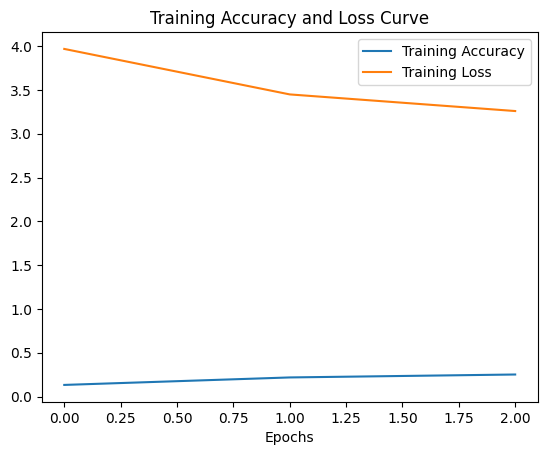

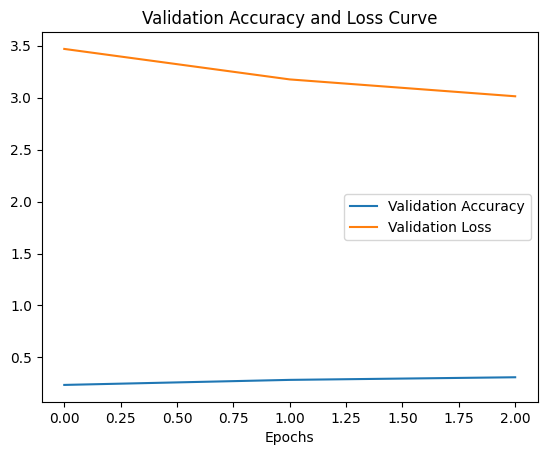

In [ ]:
# Plot the loss and accuracy curves of feature extraction model
plot_loss_curves(history=history)

## Save the whole model to a file

In [ ]:
# tf.config.run_functions_eagerly(True)

In [ ]:
# Saving the model locally (in colab)
save_model_path = "food_vision_efficientnetbo_model"
model.save(save_model_path)

In [ ]:
# Loading the saved model
loaded_model = tf.keras.models.load_model(save_model_path) 
loaded_model

In [ ]:
loaded_model.summary()

Model: "FoodVisionVGG19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling_laye  (None, 512)              0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 output_layer (Dense)        (None, 101)               51813     
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                 

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer_number, layer in enumerate(loaded_model.layers[1].layers):
  print(layer_number, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 input_1 True float32 <Policy "float32">
1 block1_conv1 False float32 <Policy "mixed_float16">
2 block1_conv2 False float32 <Policy "mixed_float16">
3 block1_pool False float32 <Policy "mixed_float16">
4 block2_conv1 False float32 <Policy "mixed_float16">
5 block2_conv2 False float32 <Policy "mixed_float16">
6 block2_pool False float32 <Policy "mixed_float16">
7 block3_conv1 False float32 <Policy "mixed_float16">
8 block3_conv2 False float32 <Policy "mixed_float16">
9 block3_conv3 False float32 <Policy "mixed_float16">
10 block3_conv4 False float32 <Policy "mixed_float16">
11 block3_pool False float32 <Policy "mixed_float16">
12 block4_conv1 False float32 <Policy "mixed_float16">
13 block4_conv2 False float32 <Policy "mixed_float16">
14 block4_conv3 False float32 <Policy "mixed_float16">
15 block4_conv4 False float32 <Policy "mixed_float16">
16 block4_pool False float32 <Policy "mixed_float16">
17 block5_conv1 False float32 <Policy "mixed_float16">
18 block5_conv2 False float32 <Polic

In [ ]:
# Check the loaded model performance on the test data (this should be the same as results_feature_extract_model)
results_saved_model = loaded_model.evaluate(test_data)
results_saved_model

790/790 [==============================] - 51s 64ms/step - loss: 3.0372 - accuracy: 0.2958


[3.0371854305267334, 0.29576238989830017]

In [ ]:
results_saved_model == results_feature_extraction_model

True

In [ ]:
import numpy as np
np.isclose(results_feature_extraction_model, results_saved_model)

array([ True,  True])

## Preparing our model's layers for fine-tuning

For fine-tuning a model:
* Set base_model.trainable = True
* Compile the model again.
* Decrease the learning rate by 1/10 (generally 1/10 is used)
* Then fit the model on the training dataset.

In [ ]:
# Set the base model .trainable to true
base_model.trainable = True

# Unfreezing the last 100 layers of the EfficientNetBx's base_model 
# for layer in model.layers[1].layers[-30:]:
#   layer.trainable = True

# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
# Create EarlyStoping Callback to stop the training the model when its stop improving it's validation loss
early_stoping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=5) # wait for the 5 epochs

# Create ModelCheckPoint Callback
checkpoint_path = f'fine_tuned_checkpoints/{model.name}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                              save_best_only=True,
                                                              save_weights_only=True,
                                                              monitor='val_loss')
# Create tensorboard callback
tensorboard_path_fine_tuning = f"tensorboard_logs/food_vision_fine_tuning/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path_fine_tuning)

# Creating learning rate reduction callback
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                          factor=0.2, # multiply the learning rate b
                                                          patience=2,
                                                          verbose=1, # print out when learning rate is reduced
                                                          min_lr=1e-8) # Minimum learning rate upto which reduction will be done

In [ ]:
# Fit the model
history_fine_tuned = model.fit(train_data,
                               epochs=100,
                               validation_data=test_data,
                               validation_steps=int(0.30 * len(test_data)),
                               callbacks=[tensorboard_callback,
                                          early_stoping_callback,
                                          model_checkpoint_callback,
                                          reduce_lr_callback])

Epoch 1/100
2368/2368 [==============================] - 652s 263ms/step - loss: 4.2536 - accuracy: 0.0573 - val_loss: 3.2233 - val_accuracy: 0.2242 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 616s 259ms/step - loss: 2.5595 - accuracy: 0.3608 - val_loss: 1.9471 - val_accuracy: 0.4827 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 613s 258ms/step - loss: 1.8909 - accuracy: 0.5165 - val_loss: 1.6815 - val_accuracy: 0.5613 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 613s 257ms/step - loss: 1.5343 - accuracy: 0.5959 - val_loss: 1.3196 - val_accuracy: 0.6387 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 609s 256ms/step - loss: 1.2526 - accuracy: 0.6640 - val_loss: 1.3177 - val_accuracy: 0.6556 - lr: 1.0000e-04
Epoch 6/100
2368/2368 [==============================] - 615s 259ms/step - loss: 1.0176 - accuracy: 0.7207 - val_loss: 1.2650 - val_accuracy: 0.6698 - lr: 1.0000e-04
Epoc

In [ ]:
# Evaluating the model on whole test data
model.evaluate(test_data)

In [ ]:
# Plot the accuracy and loss curves of the fine tuned model
plot_loss_curves(history=history_fine_tuned)

In [ ]:
# Compare history 
def compare_histories(old_history, new_history, initial_epochs):
  """
  Compare the history of two models.

  Parameters:
    old_history (object) : Tensorflow object of old history (i.e. original history)
    new_history (object) : Tensorflow object of new history (i.e. continued history from original history)
    initial_epochs (int) : Number of epochs in the original history
  """

  # Get the accuracy and loss values
  accuracy = old_history.history["accuracy"]
  loss = old_history.history["loss"]

  val_accuracy = old_history.history["val_accuracy"]
  val_loss = old_history.history["val_loss"]

  # Getting the total accuracy and loss values
  total_accuracy = accuracy + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_accuracy = val_accuracy + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  epoch = range(len(old_history.history["accuracy"]) + len(new_history.history["accuracy"]))

  # Plot the training accuracy and loss curve
  # plt.figure(figsize=(8, 8))
  # plt.subplot(2, 1, 1)
  plt.plot(epoch, total_accuracy, label="Training Accuracy")
  plt.plot(epoch, total_loss, label="Training Loss")
  plt.plot([initial_epochs-1, initial_epochs-1],
           plt.ylim(), label='Start Fine Tuning')
  plt.title("Total Training Accuracy and Loss Curve")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the test accuracy and loss curves
  # plt.subplot(2, 1, 2)
  plt.figure()
  plt.plot(epoch, total_val_accuracy, label="Validation Accuracy")
  plt.plot(epoch, total_val_loss, label="Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1],
           plt.ylim(), label='Start Fine Tuning')
  plt.title("Total Validation Accuracy and Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

In [ ]:
compare_histories(old_history=history,
                  new_history=history_fine_tuned,
                  initial_epochs=5)

In [ ]:
# Evaluate the model on 100% test data
model.evaluate(test_data)

In [ ]:
# Load the best performing model
loaded_model = tf.keras.models.load_model(checkpoint_path)
loaded_model.summary()

## Save the model

In [ ]:
# Save the model in SavedFile Format 
model.save("Food_Vision_VGG19_SavedModel")

In [ ]:
# Load the model
loaded_model = tf.keras.models.load_model("Food_Vision_VGG19_SavedModel")
loaded_model.summary()

In [ ]:
# Evaluate the loaded model
loaded_model.evaluate(test_data)

In [ ]:
# Download the saved model to local machine
# from google.colab import files
# files.download("Food_Vision_VGG19_SavedModel")